In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from matplotlib.mlab import PCA as mlabPCA # deprecated

from sqlalchemy import create_engine
import warnings

from scipy.stats.mstats import winsorize

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# drop connection
engine.dispose()

In [3]:
# imported function for removing highly correlated variables
def remove_correlated_features(dataset, threshold=0.9):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (
                corr_matrix.columns[j] not in col_corr
            ):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
                if colname in dataset.columns:
                    print(f"Deleted {colname} from dataset.")
                    del dataset[colname]

    return dataset

In [4]:
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


Column details
* Adult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population)
* Number of Infant Deaths per 1000 population
* Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol)
* Expenditure on health as a percentage of Gross Domestic Product per capita(%)
* Hepatitis B (HepB) immunization coverage among 1-year-olds (%)
* Measles - number of reported cases per 1000 population

df.describe().transpose()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [6]:
# cleaning column names

df['Life_expectancy'] = df['Life expectancy ']
df = df.drop(columns=['Life expectancy '])

df['Adult_Mortality'] = df['Adult Mortality']
df = df.drop(columns=['Adult Mortality'])

df['Measles'] = df['Measles ']
df = df.drop(columns=['Measles '])

df['BMI'] = df[' BMI ']
df = df.drop(columns=[' BMI '])

df['under-five deaths'] = df['under-five deaths ']
df = df.drop(columns=['under-five deaths '])

df['Diphtheria'] = df['Diphtheria ']
df = df.drop(columns=['Diphtheria '])

df['thinness 1-19'] = df[' thinness  1-19 years']
df = df.drop(columns=[' thinness  1-19 years'])

df['thinness 5-9'] = df[' thinness 5-9 years']
df = df.drop(columns=[' thinness 5-9 years'])

df['HIV/AIDS'] = df[' HIV/AIDS']
df = df.drop(columns=[' HIV/AIDS'])

In [7]:
# looking at nulls
df.isnull().sum()

Country                              0
Year                                 0
Status                               0
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Polio                               19
Total expenditure                  226
GDP                                448
Population                         652
Income composition of resources    167
Schooling                          163
Life_expectancy                     10
Adult_Mortality                     10
Measles                              0
BMI                                 34
under-five deaths                    0
Diphtheria                          19
thinness 1-19                       34
thinness 5-9                        34
HIV/AIDS                             0
dtype: int64

Population, GDP and Hepatitis B were respectively missing 15.25, 22.19 and 18.82% of their data. With more time, I would attempt to filling in population and GDP data from what's likely available online. Both of these variables will likely be interpolated with missing data well based on yearly data. Hepatitis may also likely have well interpolated missing data based on yearly trends. Either way, I think these percentages of missing data is acceptable.

In [8]:
# percent of nulls in vars
df.isnull().sum()*100 / df.shape[0]

Country                             0.000000
Year                                0.000000
Status                              0.000000
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Polio                               0.646698
Total expenditure                   7.692308
GDP                                15.248468
Population                         22.191967
Income composition of resources     5.684139
Schooling                           5.547992
Life_expectancy                     0.340368
Adult_Mortality                     0.340368
Measles                             0.000000
BMI                                 1.157250
under-five deaths                   0.000000
Diphtheria                          0.646698
thinness 1-19                       1.157250
thinness 5-9                        1.157250
HIV/AIDS                            0.000000
dtype: flo

In [9]:
#filling in missing nulls via interpolation because we have time ordered data   

for cols in df.columns:
    df[cols] = df[cols].interpolate(method='linear', limit_direction='both')

In [10]:
df.isnull().sum()

Country                            0
Year                               0
Status                             0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Polio                              0
Total expenditure                  0
GDP                                0
Population                         0
Income composition of resources    0
Schooling                          0
Life_expectancy                    0
Adult_Mortality                    0
Measles                            0
BMI                                0
under-five deaths                  0
Diphtheria                         0
thinness 1-19                      0
thinness 5-9                       0
HIV/AIDS                           0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   infant deaths                    2938 non-null   int64  
 4   Alcohol                          2938 non-null   float64
 5   percentage expenditure           2938 non-null   float64
 6   Hepatitis B                      2938 non-null   float64
 7   Polio                            2938 non-null   float64
 8   Total expenditure                2938 non-null   float64
 9   GDP                              2938 non-null   float64
 10  Population                       2938 non-null   float64
 11  Income composition of resources  2938 non-null   float64
 12  Schooling           

In [12]:
# looking at mean and std after interpolation
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,2938.0,2.007519e+03,4.613841e+00,2000.00000,2004.000000,2.008000e+03,2.012000e+03,2.015000e+03
infant deaths,2938.0,3.030395e+01,1.179265e+02,0.00000,0.000000,3.000000e+00,2.200000e+01,1.800000e+03
Alcohol,2938.0,4.548919e+00,3.994854e+00,0.01000,0.902500,3.697500e+00,7.550000e+00,1.787000e+01
percentage expenditure,2938.0,7.382513e+02,1.987915e+03,0.00000,4.685343,6.491291e+01,4.415341e+02,1.947991e+04
Hepatitis B,2938.0,7.853642e+01,2.517796e+01,1.00000,71.000000,8.900000e+01,9.600000e+01,9.900000e+01
Polio,2938.0,8.247464e+01,2.342069e+01,3.00000,78.000000,9.300000e+01,9.700000e+01,9.900000e+01
Total expenditure,2938.0,5.940955e+00,2.445751e+00,0.37000,4.312500,5.760000e+00,7.440000e+00,1.760000e+01
GDP,2938.0,7.432028e+03,1.341015e+04,1.68135,553.618620,2.192681e+03,7.183382e+03,1.191727e+05
Population,2938.0,1.229209e+07,5.471908e+07,34.00000,253602.500000,1.576319e+06,8.215738e+06,1.293859e+09
Income composition of resources,2938.0,6.344585e-01,2.095741e-01,0.00000,0.500000,6.840000e-01,7.911071e-01,9.480000e-01


# Your goal in this challenge is to find the factors that affect life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

1. Detect the problems with the data, such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable for filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.


2. Explore the data using univariate and multivariate exploration techniques. Be sure to pay special attention to your target variable. In this regard, focus on finding the relevant variables that may affect life expectancy.
    

3. In the feature-engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are highly correlated with the other ones or the variables that you think are irrelevant with the life expectancy.


4. Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

In [14]:
#sns.pairplot(df)
#plt.show()

In [15]:
# making a list of columns to detect outliers excluding categorical data
df.columns

Index(['Country', 'Year', 'Status', 'infant deaths', 'Alcohol',
       'percentage expenditure', 'Hepatitis B', 'Polio', 'Total expenditure',
       'GDP', 'Population', 'Income composition of resources', 'Schooling',
       'Life_expectancy', 'Adult_Mortality', 'Measles', 'BMI',
       'under-five deaths', 'Diphtheria', 'thinness 1-19', 'thinness 5-9',
       'HIV/AIDS'],
      dtype='object')

In [16]:
variables = ['infant deaths', 'Alcohol',
       'percentage expenditure', 'Hepatitis B', 'Polio', 'Total expenditure',
       'GDP', 'Population', 'Income composition of resources', 'Schooling',
       'Life_expectancy', 'Adult_Mortality', 'Measles', 'BMI',
       'under-five deaths', 'Diphtheria', 'thinness 1-19', 'thinness 5-9',
       'HIV/AIDS']

for col in variables:
    for threshold in np.arange(1,5,0.5):
        q75, q25 = np.percentile(df[col], [75 ,25])
        iqr = q75 - q25
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
        print("The score threshold is: {} for {}".format(threshold, col))
        print("Number of outliers is: {}".format(
            len((np.where((df[col] > max_val) | (df[col] < min_val))[0]))
    ))

The score threshold is: 1.0 for infant deaths
Number of outliers is: 419
The score threshold is: 1.5 for infant deaths
Number of outliers is: 315
The score threshold is: 2.0 for infant deaths
Number of outliers is: 226
The score threshold is: 2.5 for infant deaths
Number of outliers is: 187
The score threshold is: 3.0 for infant deaths
Number of outliers is: 158
The score threshold is: 3.5 for infant deaths
Number of outliers is: 138
The score threshold is: 4.0 for infant deaths
Number of outliers is: 130
The score threshold is: 4.5 for infant deaths
Number of outliers is: 121
The score threshold is: 1.0 for Alcohol
Number of outliers is: 18
The score threshold is: 1.5 for Alcohol
Number of outliers is: 1
The score threshold is: 2.0 for Alcohol
Number of outliers is: 0
The score threshold is: 2.5 for Alcohol
Number of outliers is: 0
The score threshold is: 3.0 for Alcohol
Number of outliers is: 0
The score threshold is: 3.5 for Alcohol
Number of outliers is: 0
The score threshold is: 4

All numeric variables have outliers above 1 x IQR except for BMI. Population, GDP, HIV, under5deaths, measles, percentage expenditure and infant deaths all have outliers above 4 x IQR. The dataset was missing from 18 to 67.5% of it's data before interpolation so with a dataset of 2938 remaing, we should transform outliers and keep them for analysis especially since many of them may help explain life expectancy.
    
    Percent of missing data before interpolation
    * Hepatitis B                        18.822328
    * GDP                                15.248468
    * Population                         22.191967
    * Income composition of resources     5.684139
    * Schooling                           5.547992

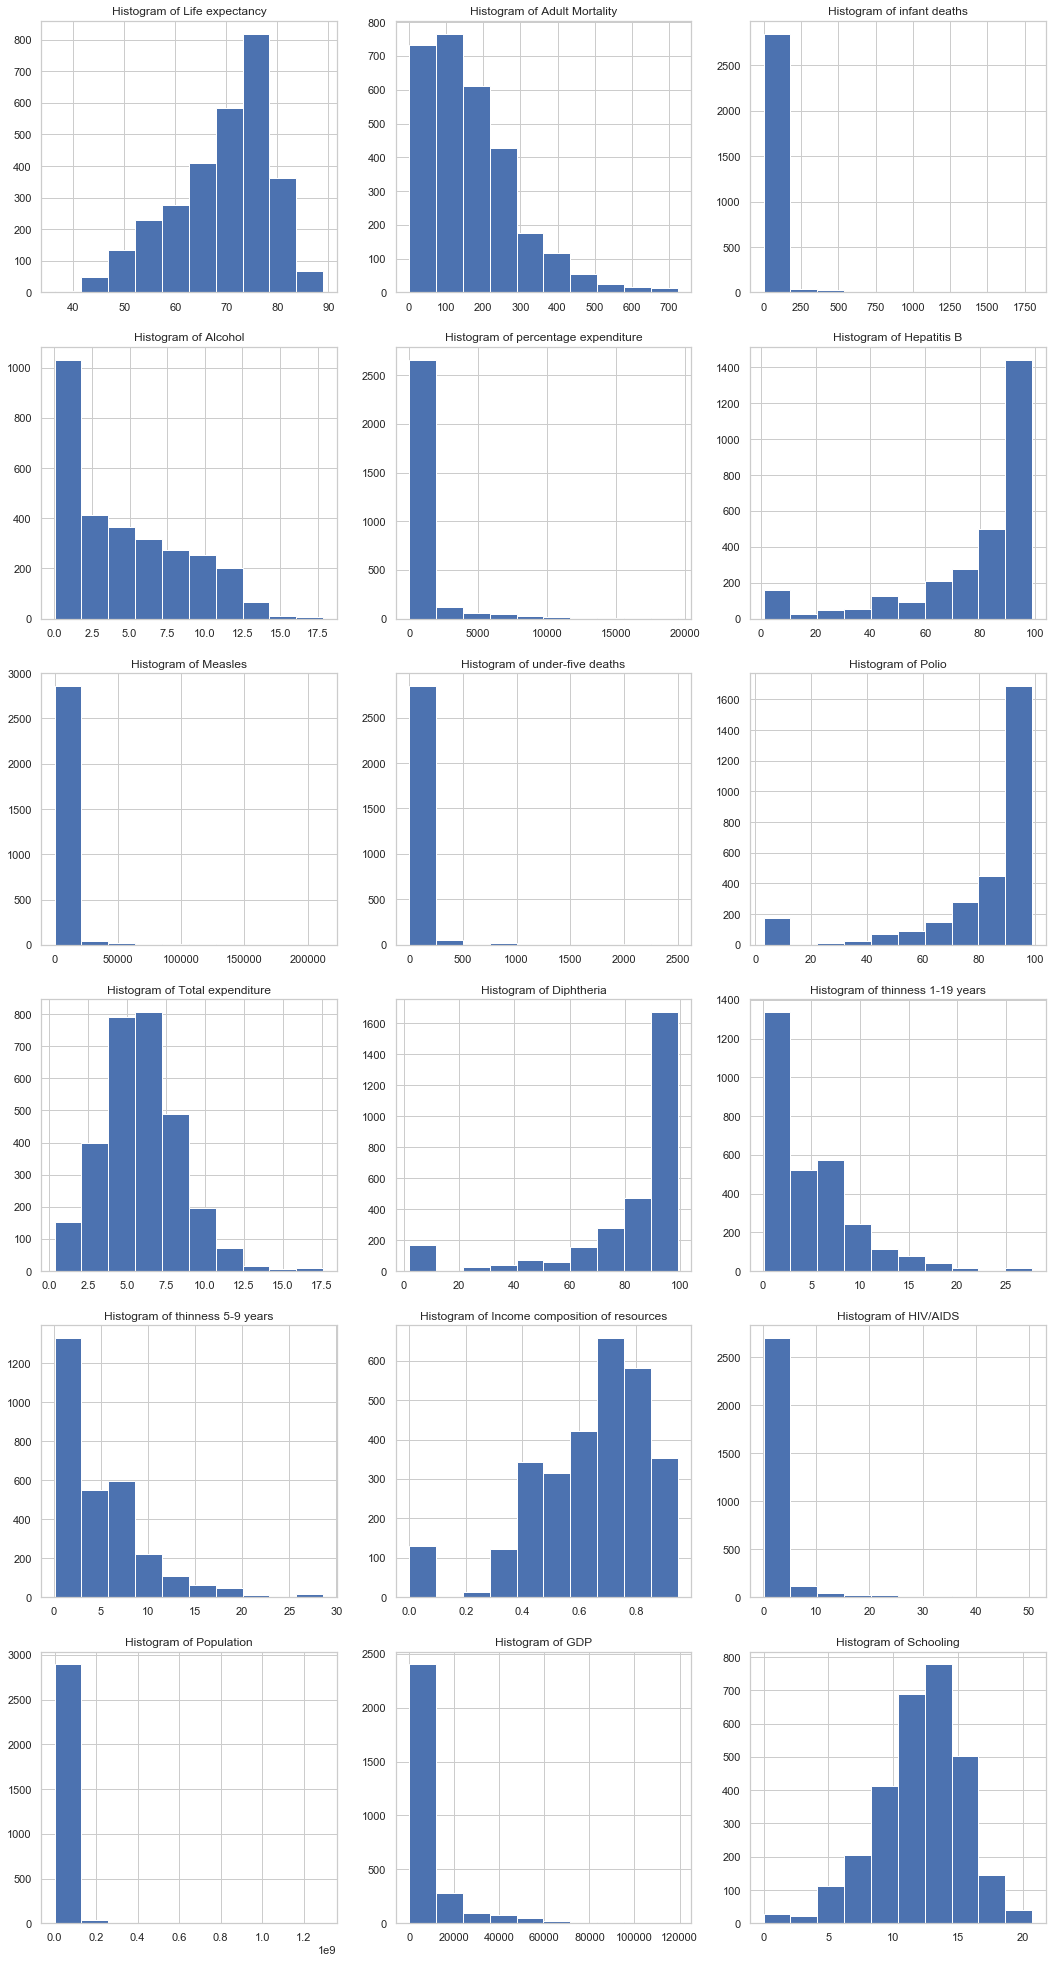

In [17]:
# distributions of numeric vars before removing outliers

plt.figure(figsize=(18,35))

plt.subplot(6, 3, 1)
plt.hist(df["Life_expectancy"])
plt.title("Histogram of Life expectancy" )

plt.subplot(6, 3, 2)
plt.hist(df["Adult_Mortality"])
plt.title("Histogram of Adult Mortality")

plt.subplot(6, 3, 3)
plt.hist(df["infant deaths"])
plt.title("Histogram of infant deaths")

plt.subplot(6, 3, 4)
plt.hist(df["Alcohol"])
plt.title("Histogram of Alcohol")

plt.subplot(6, 3, 5)
plt.hist(df["percentage expenditure"])
plt.title("Histogram of percentage expenditure")

plt.subplot(6, 3, 6)
plt.hist(df["Hepatitis B"])
plt.title("Histogram of Hepatitis B")

plt.subplot(6, 3, 7)
plt.hist(df["Measles"])
plt.title("Histogram of Measles" )

plt.subplot(6, 3, 8)
plt.hist(df["under-five deaths"])
plt.title("Histogram of under-five deaths")

plt.subplot(6, 3, 9)
plt.hist(df["Polio"])
plt.title("Histogram of Polio")

plt.subplot(6, 3, 10)
plt.hist(df["Total expenditure"])
plt.title("Histogram of Total expenditure")

plt.subplot(6, 3, 11)
plt.hist(df["Diphtheria"])
plt.title("Histogram of Diphtheria")

plt.subplot(6, 3, 12)
plt.hist(df["thinness 1-19"])
plt.title("Histogram of thinness 1-19 years" )

plt.subplot(6, 3, 13)
plt.hist(df["thinness 5-9"])
plt.title("Histogram of thinness 5-9 years")

plt.subplot(6, 3, 14)
plt.hist(df["Income composition of resources"])
plt.title("Histogram of Income composition of resources")

plt.subplot(6, 3, 15)
plt.hist(df["HIV/AIDS"])
plt.title("Histogram of HIV/AIDS")

plt.subplot(6, 3, 16)
plt.hist(df["Population"])
plt.title("Histogram of Population")

plt.subplot(6, 3, 17)
plt.hist(df["GDP"])
plt.title("Histogram of GDP")

plt.subplot(6, 3, 18)
plt.hist(df["Schooling"])
plt.title("Histogram of Schooling")

plt.show()

In [18]:
df.isna().any()

Country                            False
Year                               False
Status                             False
infant deaths                      False
Alcohol                            False
percentage expenditure             False
Hepatitis B                        False
Polio                              False
Total expenditure                  False
GDP                                False
Population                         False
Income composition of resources    False
Schooling                          False
Life_expectancy                    False
Adult_Mortality                    False
Measles                            False
BMI                                False
under-five deaths                  False
Diphtheria                         False
thinness 1-19                      False
thinness 5-9                       False
HIV/AIDS                           False
dtype: bool

Below investigates effects of transforming variables to eliminate outliers by comparing original variable data, log data and square root of variable.

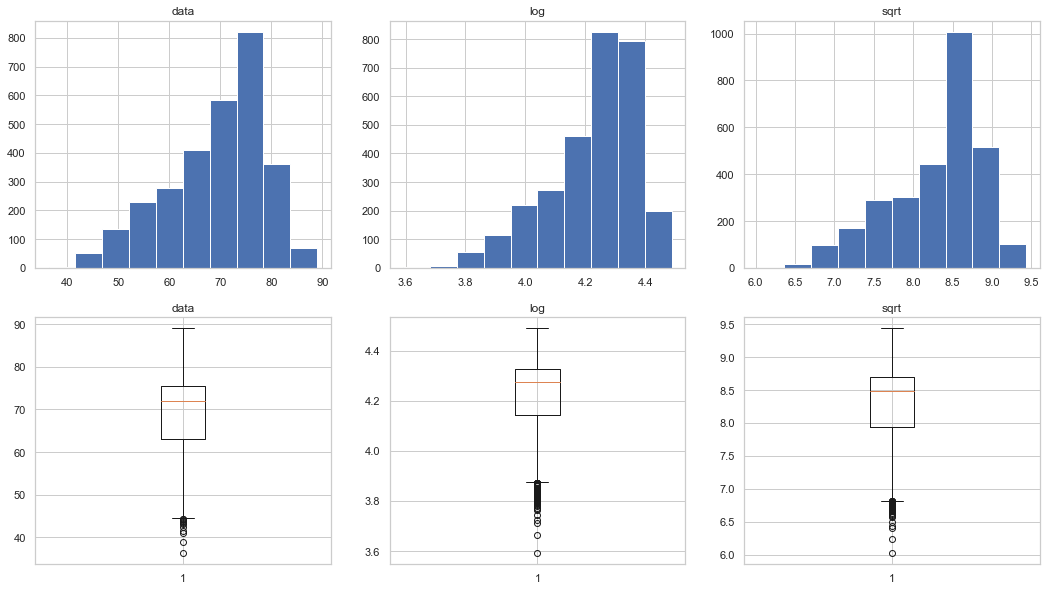

In [19]:
hist_label = df['Life_expectancy']

log_views = np.log(hist_label)

sqrt_views = np.sqrt(hist_label)

plt.figure(figsize=(18,10))

plt.subplot(2, 3, 1)
plt.hist(hist_label)
plt.title('data')

plt.subplot(2, 3, 2)
plt.hist(log_views)
plt.title("log")

plt.subplot(2, 3, 3)
plt.hist(sqrt_views)
plt.title("sqrt")

plt.subplot(2, 3, 4)
plt.boxplot(hist_label)
plt.title('data')

plt.subplot(2, 3, 5)
plt.boxplot(log_views)
plt.title("log")

plt.subplot(2, 3, 6)
plt.boxplot(sqrt_views)
plt.title("sqrt")

plt.show()

Transformation of life expectancy is improved by the log but will leave this variable unchanged since it's our target.

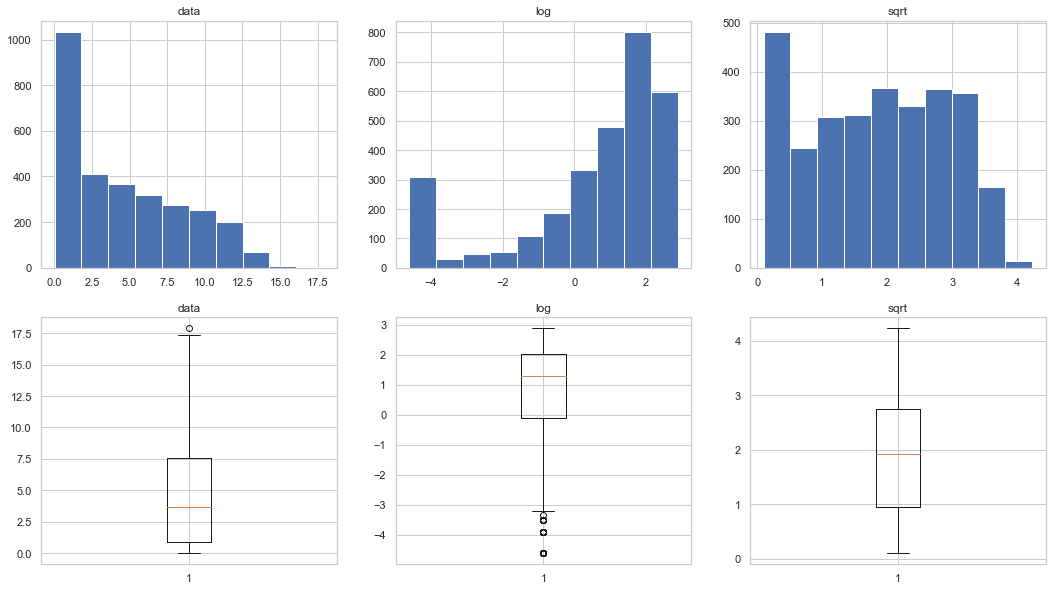

In [20]:
hist_label = df['Alcohol']

log_views = np.log(hist_label)

sqrt_views = np.sqrt(hist_label)

plt.figure(figsize=(18,10))

plt.subplot(2, 3, 1)
plt.hist(hist_label)
plt.title('data')

plt.subplot(2, 3, 2)
plt.hist(log_views)
plt.title("log")

plt.subplot(2, 3, 3)
plt.hist(sqrt_views)
plt.title("sqrt")

plt.subplot(2, 3, 4)
plt.boxplot(hist_label)
plt.title('data')

plt.subplot(2, 3, 5)
plt.boxplot(log_views)
plt.title("log")

plt.subplot(2, 3, 6)
plt.boxplot(sqrt_views)
plt.title("sqrt")

plt.show()

The alcohol variable only had 19 outliers and transformation does not really improve it so will use unchanged data. 

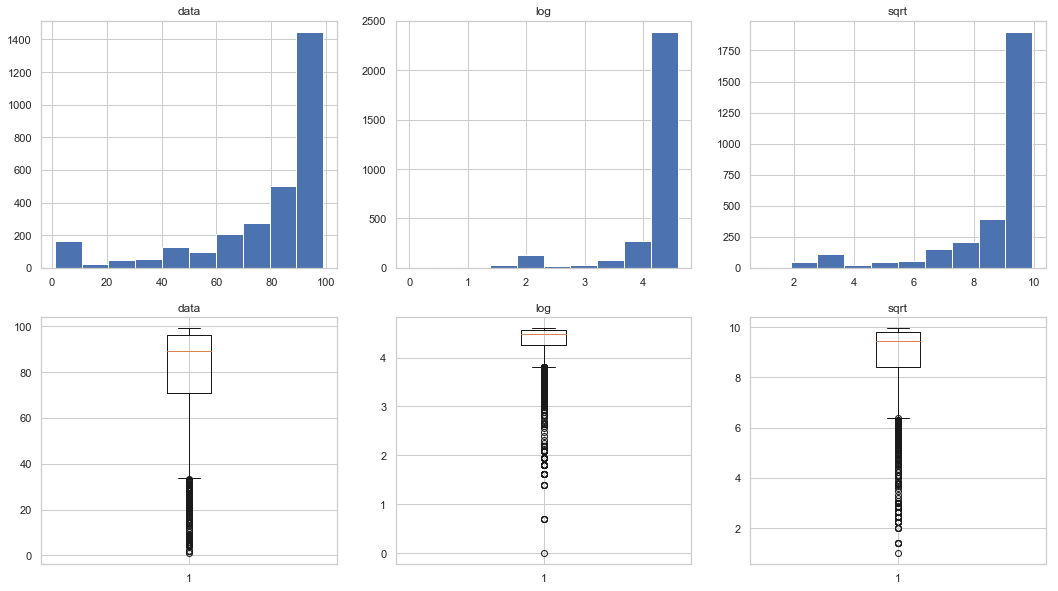

In [21]:
hist_label = df['Hepatitis B']

log_views = np.log(hist_label)

sqrt_views = np.sqrt(hist_label)

plt.figure(figsize=(18,10))

plt.subplot(2, 3, 1)
plt.hist(hist_label)
plt.title('data')

plt.subplot(2, 3, 2)
plt.hist(log_views)
plt.title("log")

plt.subplot(2, 3, 3)
plt.hist(sqrt_views)
plt.title("sqrt")

plt.subplot(2, 3, 4)
plt.boxplot(hist_label)
plt.title('data')

plt.subplot(2, 3, 5)
plt.boxplot(log_views)
plt.title("log")

plt.subplot(2, 3, 6)
plt.boxplot(sqrt_views)
plt.title("sqrt")

plt.show()

Hepatitis outliers do not really respond to transformation.

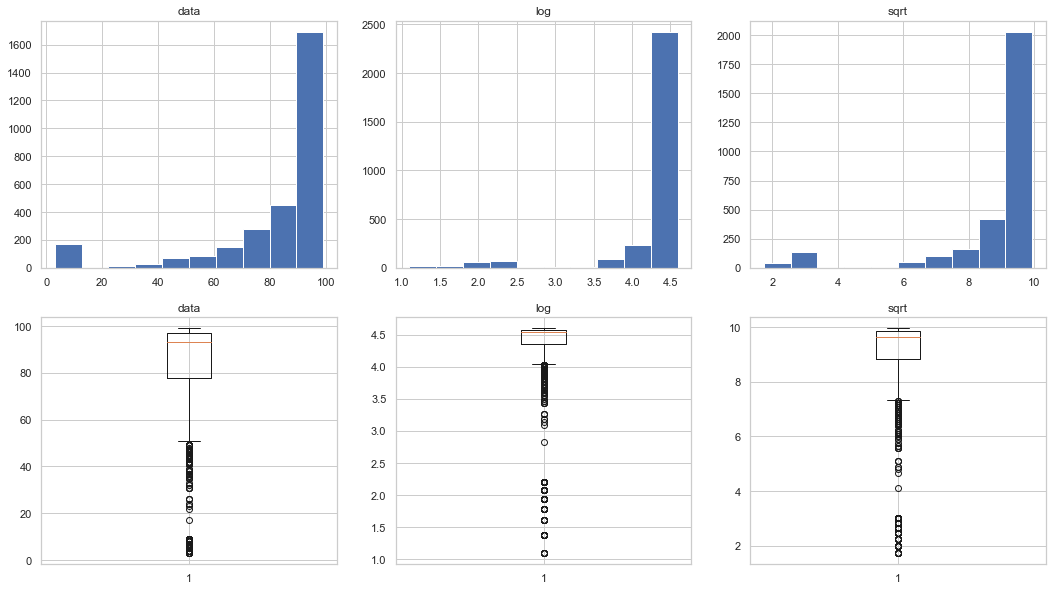

In [22]:
hist_label = df['Polio']

log_views = np.log(hist_label)

sqrt_views = np.sqrt(hist_label)

plt.figure(figsize=(18,10))

plt.subplot(2, 3, 1)
plt.hist(hist_label)
plt.title('data')

plt.subplot(2, 3, 2)
plt.hist(log_views)
plt.title("log")

plt.subplot(2, 3, 3)
plt.hist(sqrt_views)
plt.title("sqrt")

plt.subplot(2, 3, 4)
plt.boxplot(hist_label)
plt.title('data')

plt.subplot(2, 3, 5)
plt.boxplot(log_views)
plt.title("log")

plt.subplot(2, 3, 6)
plt.boxplot(sqrt_views)
plt.title("sqrt")

plt.show()

Transformation of Polio variable does not really remove outliers. 

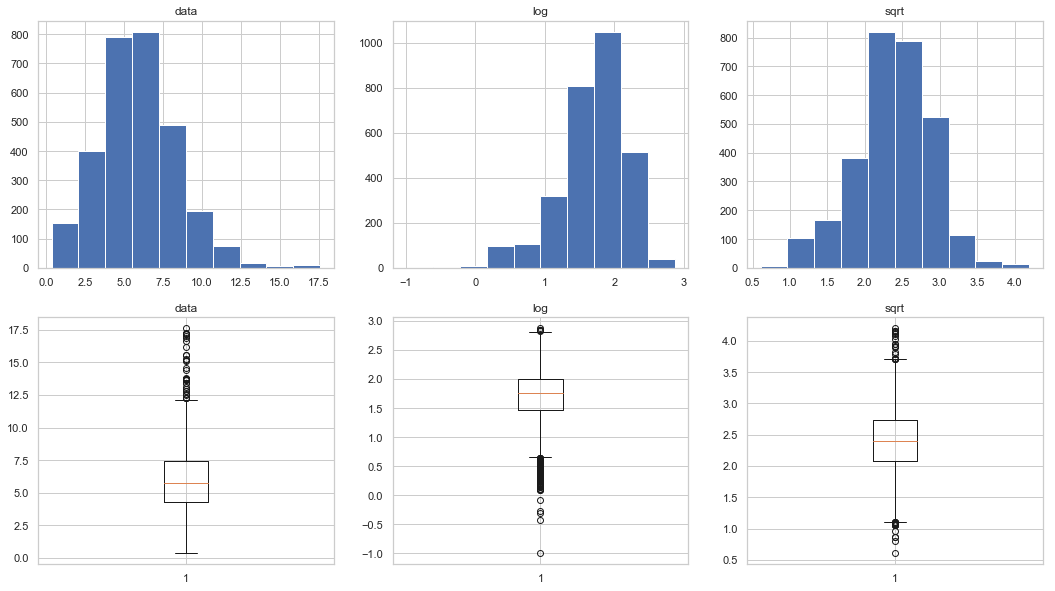

In [23]:
hist_label = df['Total expenditure']

log_views = np.log(hist_label)

sqrt_views = np.sqrt(hist_label)

plt.figure(figsize=(18,10))

plt.subplot(2, 3, 1)
plt.hist(hist_label)
plt.title('data')

plt.subplot(2, 3, 2)
plt.hist(log_views)
plt.title("log")

plt.subplot(2, 3, 3)
plt.hist(sqrt_views)
plt.title("sqrt")

plt.subplot(2, 3, 4)
plt.boxplot(hist_label)
plt.title('data')

plt.subplot(2, 3, 5)
plt.boxplot(log_views)
plt.title("log")

plt.subplot(2, 3, 6)
plt.boxplot(sqrt_views)
plt.title("sqrt")

plt.show()

Square rt transform of total expenditures improves distribution but doesn't really remove outliers.

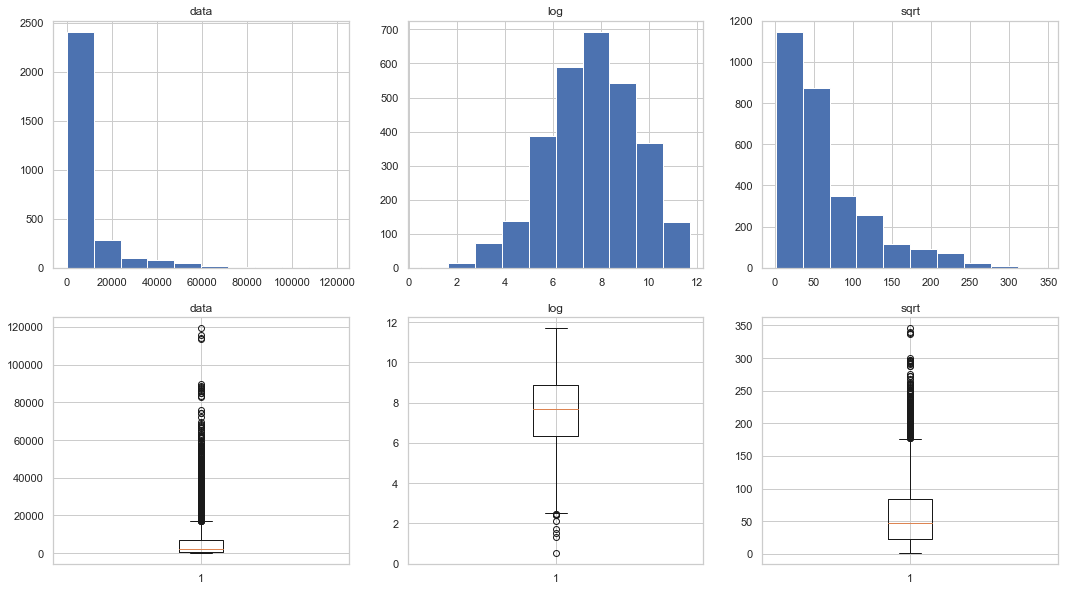

In [24]:
hist_label = df['GDP']

log_views = np.log(hist_label)

sqrt_views = np.sqrt(hist_label)

plt.figure(figsize=(18,10))

plt.subplot(2, 3, 1)
plt.hist(hist_label)
plt.title('data')

plt.subplot(2, 3, 2)
plt.hist(log_views)
plt.title("log")

plt.subplot(2, 3, 3)
plt.hist(sqrt_views)
plt.title("sqrt")

plt.subplot(2, 3, 4)
plt.boxplot(hist_label)
plt.title('data')

plt.subplot(2, 3, 5)
plt.boxplot(log_views)
plt.title("log")

plt.subplot(2, 3, 6)
plt.boxplot(sqrt_views)
plt.title("sqrt")

plt.show()

The log transform of GDP removes many outliers and improves distribution.

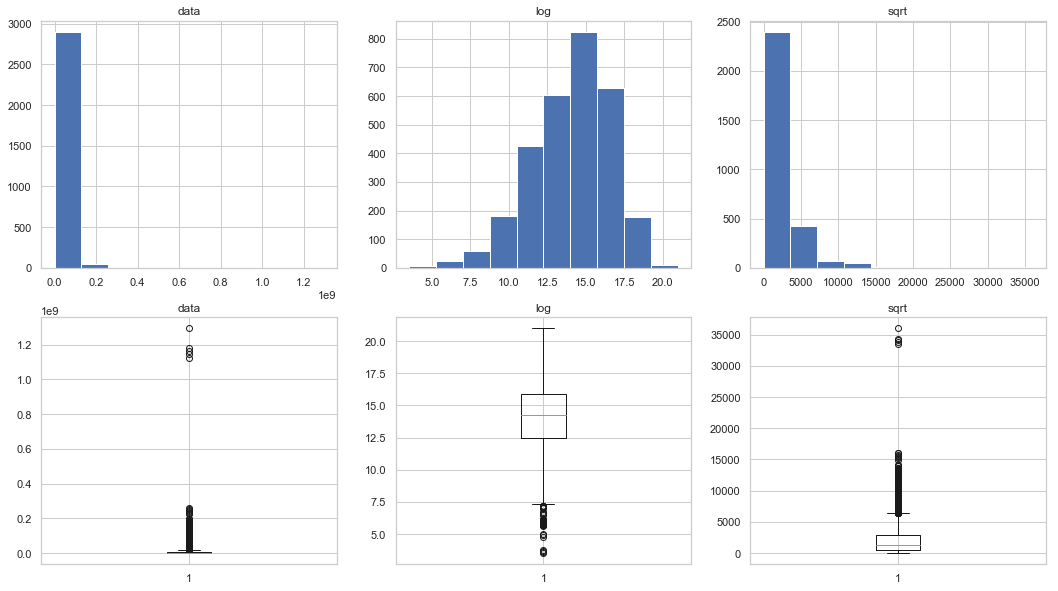

In [25]:
hist_label = df['Population']

log_views = np.log(hist_label)

sqrt_views = np.sqrt(hist_label)

plt.figure(figsize=(18,10))

plt.subplot(2, 3, 1)
plt.hist(hist_label)
plt.title('data')

plt.subplot(2, 3, 2)
plt.hist(log_views)
plt.title("log")

plt.subplot(2, 3, 3)
plt.hist(sqrt_views)
plt.title("sqrt")

plt.subplot(2, 3, 4)
plt.boxplot(hist_label)
plt.title('data')

plt.subplot(2, 3, 5)
plt.boxplot(log_views)
plt.title("log")

plt.subplot(2, 3, 6)
plt.boxplot(sqrt_views)
plt.title("sqrt")

plt.show()

The log transform of population improves distribution and does remove many outliers.

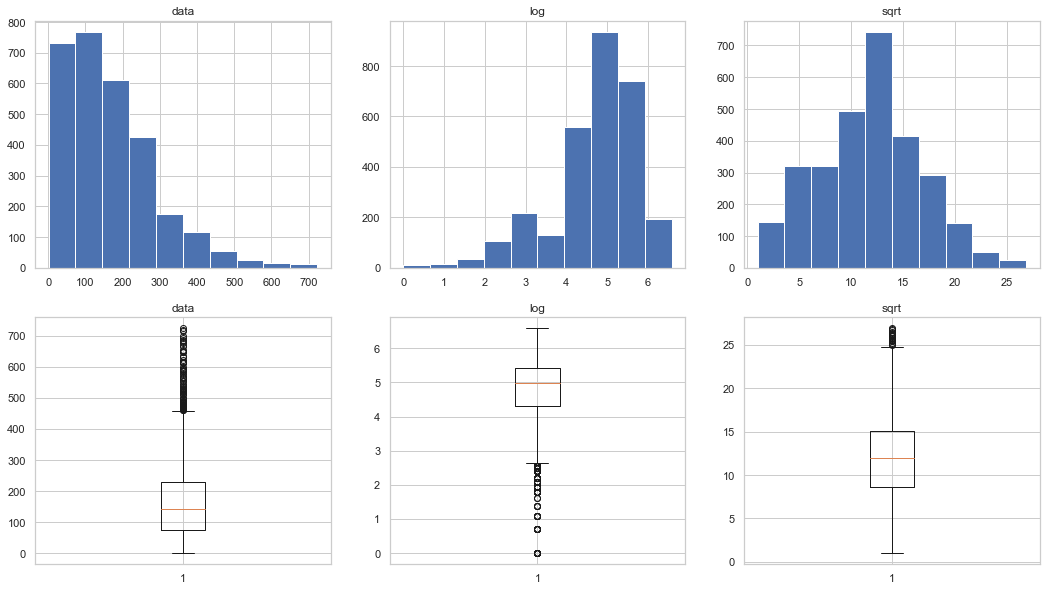

In [26]:
hist_label = df['Adult_Mortality']

log_views = np.log(hist_label)

sqrt_views = np.sqrt(hist_label)

plt.figure(figsize=(18,10))

plt.subplot(2, 3, 1)
plt.hist(hist_label)
plt.title('data')

plt.subplot(2, 3, 2)
plt.hist(log_views)
plt.title("log")

plt.subplot(2, 3, 3)
plt.hist(sqrt_views)
plt.title("sqrt")

plt.subplot(2, 3, 4)
plt.boxplot(hist_label)
plt.title('data')

plt.subplot(2, 3, 5)
plt.boxplot(log_views)
plt.title("log")

plt.subplot(2, 3, 6)
plt.boxplot(sqrt_views)
plt.title("sqrt")

plt.show()

It appears that a square root transform of adult mortality and the log removes many outliers but sqrt distribution is best.

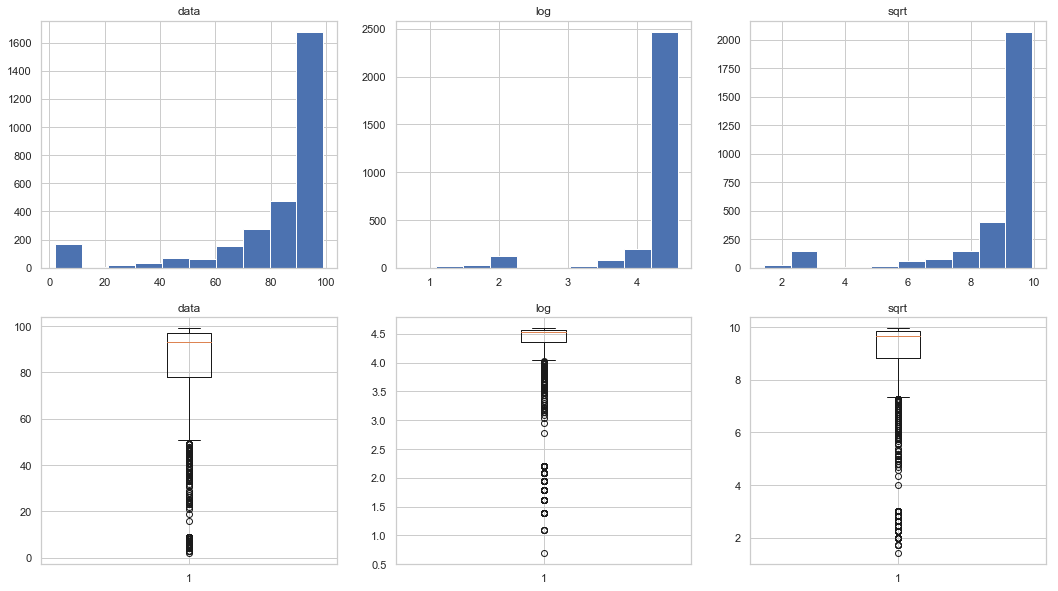

In [27]:
hist_label = df['Diphtheria']

log_views = np.log(hist_label)

sqrt_views = np.sqrt(hist_label)

plt.figure(figsize=(18,10))

plt.subplot(2, 3, 1)
plt.hist(hist_label)
plt.title('data')

plt.subplot(2, 3, 2)
plt.hist(log_views)
plt.title("log")

plt.subplot(2, 3, 3)
plt.hist(sqrt_views)
plt.title("sqrt")

plt.subplot(2, 3, 4)
plt.boxplot(hist_label)
plt.title('data')

plt.subplot(2, 3, 5)
plt.boxplot(log_views)
plt.title("log")

plt.subplot(2, 3, 6)
plt.boxplot(sqrt_views)
plt.title("sqrt")

plt.show()

Diphtheria is mostly unresponsive to transform in distribution and outliers.

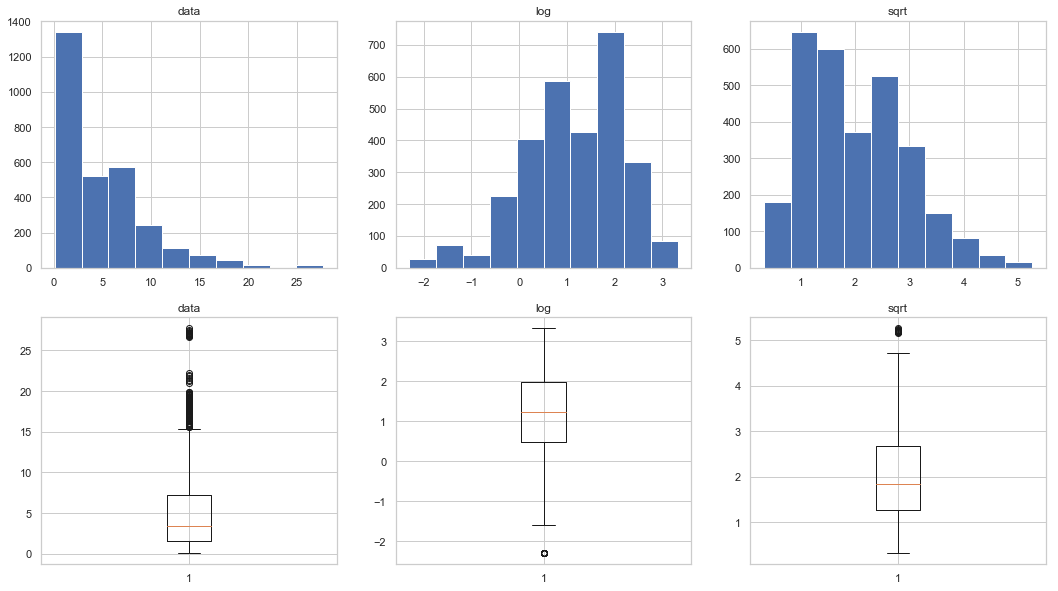

In [28]:
hist_label = df['thinness 1-19']

log_views = np.log(hist_label)

sqrt_views = np.sqrt(hist_label)

plt.figure(figsize=(18,10))

plt.subplot(2, 3, 1)
plt.hist(hist_label)
plt.title('data')

plt.subplot(2, 3, 2)
plt.hist(log_views)
plt.title("log")

plt.subplot(2, 3, 3)
plt.hist(sqrt_views)
plt.title("sqrt")

plt.subplot(2, 3, 4)
plt.boxplot(hist_label)
plt.title('data')

plt.subplot(2, 3, 5)
plt.boxplot(log_views)
plt.title("log")

plt.subplot(2, 3, 6)
plt.boxplot(sqrt_views)
plt.title("sqrt")

plt.show()

Thinness in 1 to 19 year olds is improved by transforming by the log.

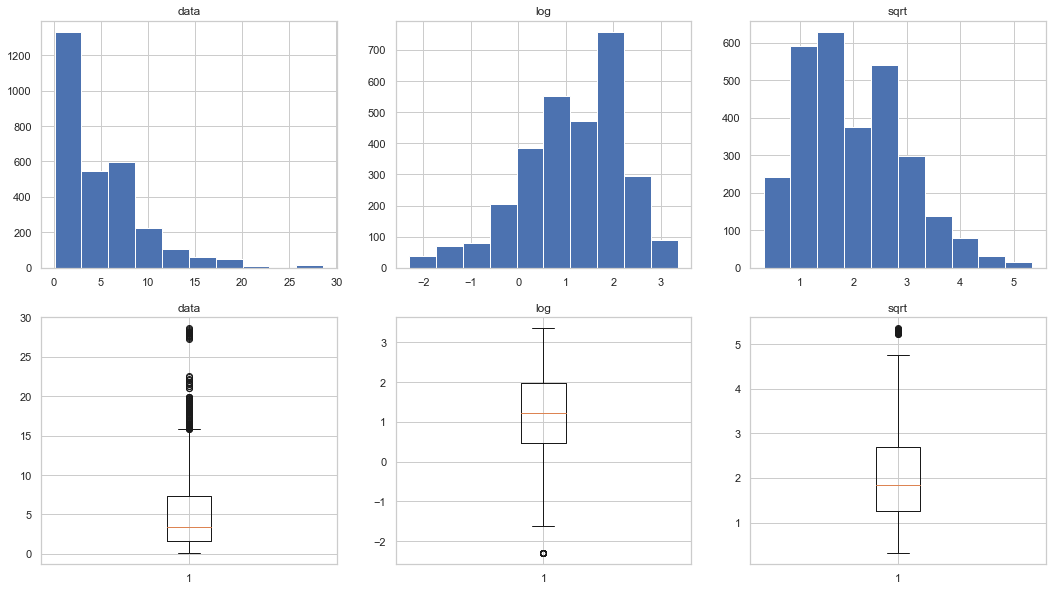

In [29]:
hist_label = df['thinness 5-9']

log_views = np.log(hist_label)

sqrt_views = np.sqrt(hist_label)

plt.figure(figsize=(18,10))

plt.subplot(2, 3, 1)
plt.hist(hist_label)
plt.title('data')

plt.subplot(2, 3, 2)
plt.hist(log_views)
plt.title("log")

plt.subplot(2, 3, 3)
plt.hist(sqrt_views)
plt.title("sqrt")

plt.subplot(2, 3, 4)
plt.boxplot(hist_label)
plt.title('data')

plt.subplot(2, 3, 5)
plt.boxplot(log_views)
plt.title("log")

plt.subplot(2, 3, 6)
plt.boxplot(sqrt_views)
plt.title("sqrt")

plt.show()

Similarly, the log transform improved the distribution and outlier removal here as well.

In [30]:
df.columns

Index(['Country', 'Year', 'Status', 'infant deaths', 'Alcohol',
       'percentage expenditure', 'Hepatitis B', 'Polio', 'Total expenditure',
       'GDP', 'Population', 'Income composition of resources', 'Schooling',
       'Life_expectancy', 'Adult_Mortality', 'Measles', 'BMI',
       'under-five deaths', 'Diphtheria', 'thinness 1-19', 'thinness 5-9',
       'HIV/AIDS'],
      dtype='object')

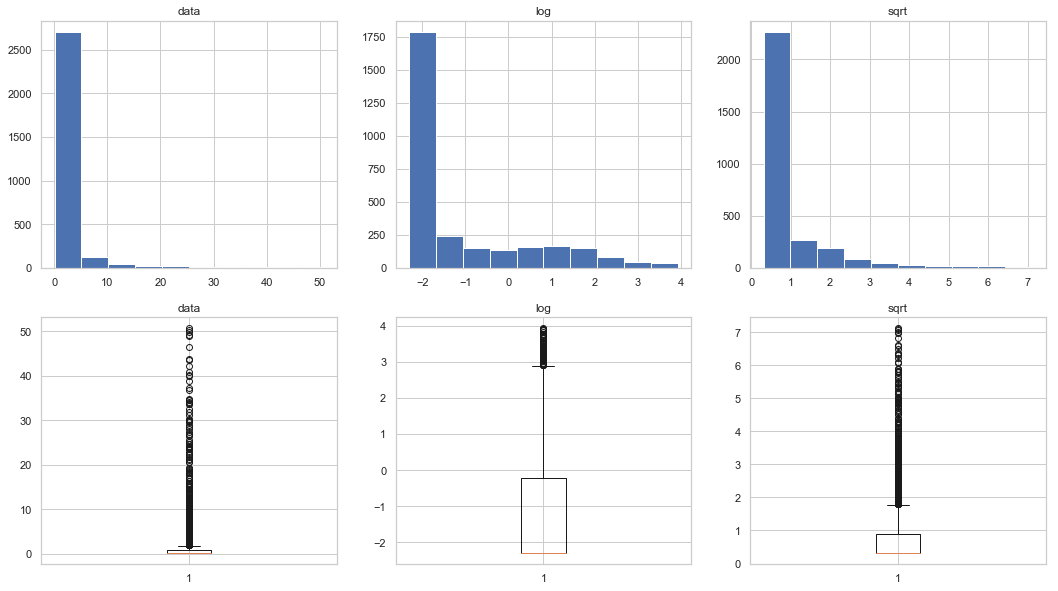

In [31]:
hist_label = df['HIV/AIDS']

log_views = np.log(hist_label)

sqrt_views = np.sqrt(hist_label)

plt.figure(figsize=(18,10))

plt.subplot(2, 3, 1)
plt.hist(hist_label)
plt.title('data')

plt.subplot(2, 3, 2)
plt.hist(log_views)
plt.title("log")

plt.subplot(2, 3, 3)
plt.hist(sqrt_views)
plt.title("sqrt")

plt.subplot(2, 3, 4)
plt.boxplot(hist_label)
plt.title('data')

plt.subplot(2, 3, 5)
plt.boxplot(log_views)
plt.title("log")

plt.subplot(2, 3, 6)
plt.boxplot(sqrt_views)
plt.title("sqrt")

plt.show()

Transformations did not appear to improve distribution or remove outliers from HIV variable.

In [32]:
df['HIV/AIDS'].describe()

count    2938.000000
mean        1.742103
std         5.077785
min         0.100000
25%         0.100000
50%         0.100000
75%         0.800000
max        50.600000
Name: HIV/AIDS, dtype: float64

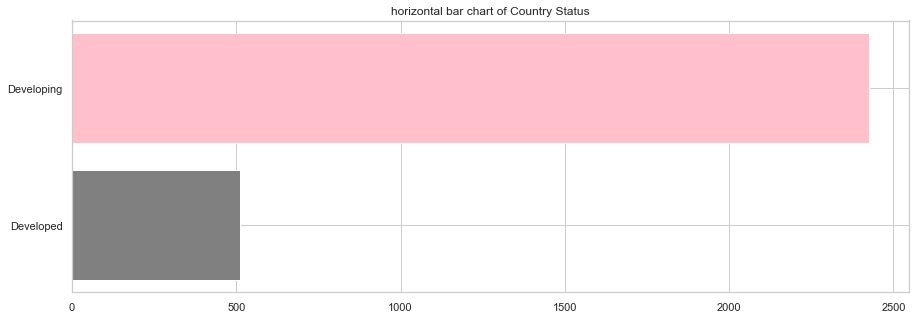

In [33]:
plt.figure(figsize=(15,5))
plt.barh(df.groupby("Status")["Status"].count().index, 
        df.groupby("Status")["Status"].count(), 
        color=["grey","pink"])
plt.title("horizontal bar chart of Country Status")

plt.show()

Transformations improved the following 5 variables. 
SQRT:  Adult_Mortality, 
LOG:  GDP, Population, thinness 5-9, thinness 1-19, 

Not able to transform the following variables error msg says "not finite". Will add 1 to each value in each column to eliminate zero values.
infant deaths, percentage expenditure, Income composition of resources, Schooling, Measles, under-five deaths

So far, will transform 5 vars as above and then remove remaining outliers above threshold of 3. Will do a multivariate analysis and see what is revealed.

In [34]:
df['infant deaths'] = df['infant deaths'] +1 

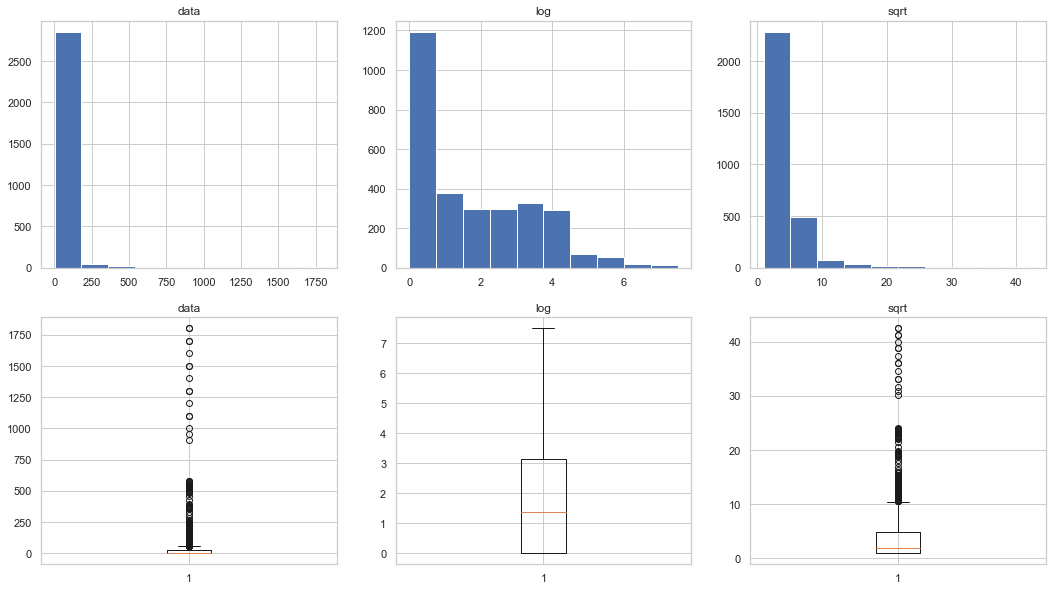

In [35]:
hist_label = df['infant deaths']

log_views = np.log(hist_label)

sqrt_views = np.sqrt(hist_label)

plt.figure(figsize=(18,10))

plt.subplot(2, 3, 1)
plt.hist(hist_label)
plt.title('data')

plt.subplot(2, 3, 2)
plt.hist(log_views)
plt.title("log")

plt.subplot(2, 3, 3)
plt.hist(sqrt_views)
plt.title("sqrt")

plt.subplot(2, 3, 4)
plt.boxplot(hist_label)
plt.title('data')

plt.subplot(2, 3, 5)
plt.boxplot(log_views)
plt.title("log")

plt.subplot(2, 3, 6)
plt.boxplot(sqrt_views)
plt.title("sqrt")

plt.show()

Outliers are removed by the log transform of infant death values but distribution is still not normal. 

In [36]:
df['percentage expenditure'] = df['percentage expenditure'] +1 

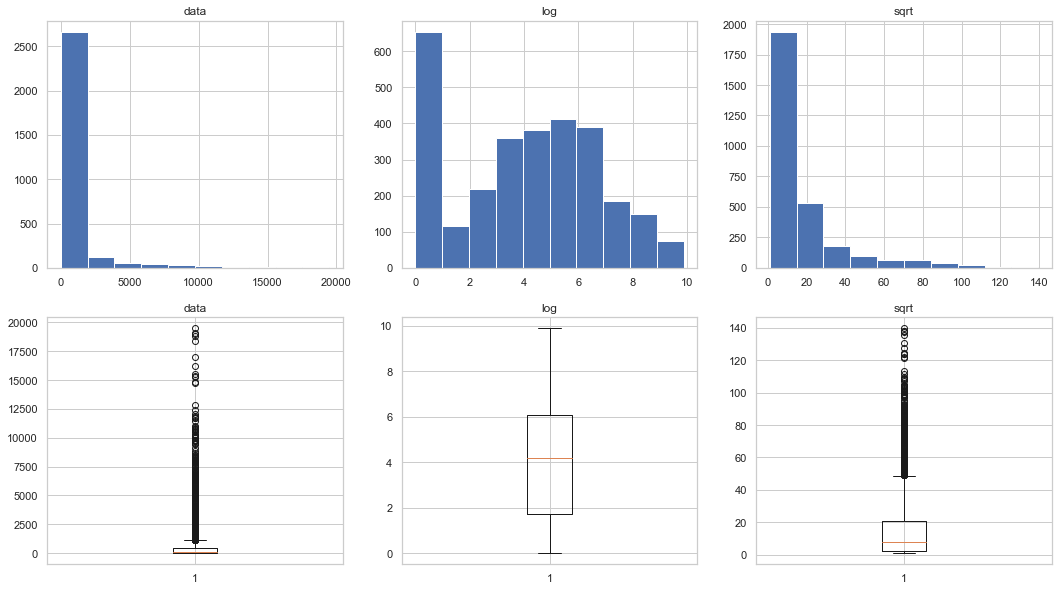

In [37]:
hist_label = df['percentage expenditure']

log_views = np.log(hist_label)

sqrt_views = np.sqrt(hist_label)

plt.figure(figsize=(18,10))

plt.subplot(2, 3, 1)
plt.hist(hist_label)
plt.title('data')

plt.subplot(2, 3, 2)
plt.hist(log_views)
plt.title("log")

plt.subplot(2, 3, 3)
plt.hist(sqrt_views)
plt.title("sqrt")

plt.subplot(2, 3, 4)
plt.boxplot(hist_label)
plt.title('data')

plt.subplot(2, 3, 5)
plt.boxplot(log_views)
plt.title("log")

plt.subplot(2, 3, 6)
plt.boxplot(sqrt_views)
plt.title("sqrt")

plt.show()

Percentage expenditure was greatly improved by the log transform in removing outliers but not yet normally distributed.

In [38]:
df['Income composition of resources'] = df['Income composition of resources'] +1 

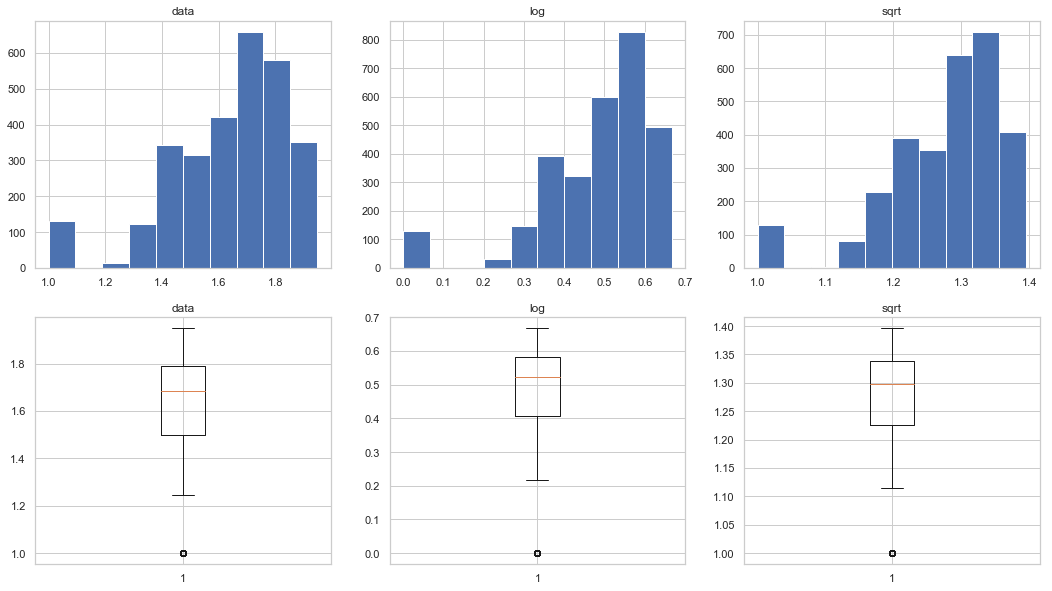

In [39]:
hist_label = df['Income composition of resources']

log_views = np.log(hist_label)

sqrt_views = np.sqrt(hist_label)

plt.figure(figsize=(18,10))

plt.subplot(2, 3, 1)
plt.hist(hist_label)
plt.title('data')

plt.subplot(2, 3, 2)
plt.hist(log_views)
plt.title("log")

plt.subplot(2, 3, 3)
plt.hist(sqrt_views)
plt.title("sqrt")

plt.subplot(2, 3, 4)
plt.boxplot(hist_label)
plt.title('data')

plt.subplot(2, 3, 5)
plt.boxplot(log_views)
plt.title("log")

plt.subplot(2, 3, 6)
plt.boxplot(sqrt_views)
plt.title("sqrt")

plt.show()

Log transform did not impact income comp of resources variable much. Will leave alone.

In [40]:
df['Schooling'] = df['Schooling'] +1 

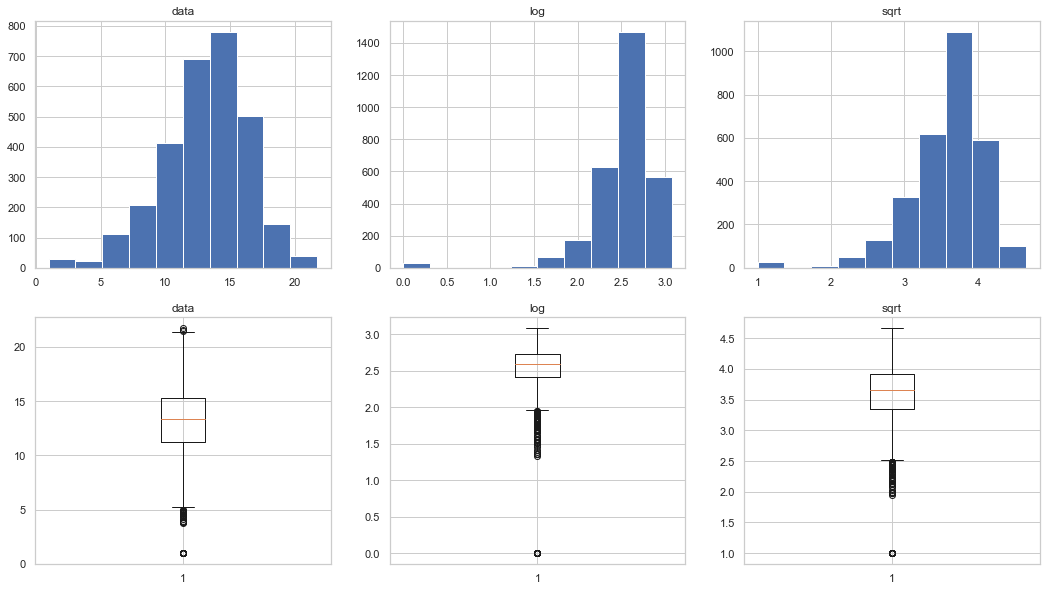

In [41]:
hist_label = df['Schooling']

log_views = np.log(hist_label)

sqrt_views = np.sqrt(hist_label)

plt.figure(figsize=(18,10))

plt.subplot(2, 3, 1)
plt.hist(hist_label)
plt.title('data')

plt.subplot(2, 3, 2)
plt.hist(log_views)
plt.title("log")

plt.subplot(2, 3, 3)
plt.hist(sqrt_views)
plt.title("sqrt")

plt.subplot(2, 3, 4)
plt.boxplot(hist_label)
plt.title('data')

plt.subplot(2, 3, 5)
plt.boxplot(log_views)
plt.title("log")

plt.subplot(2, 3, 6)
plt.boxplot(sqrt_views)
plt.title("sqrt")

plt.show()

Will leave schooling variable unchanged. 

In [42]:
df['Measles'] = df['Measles'] +1 

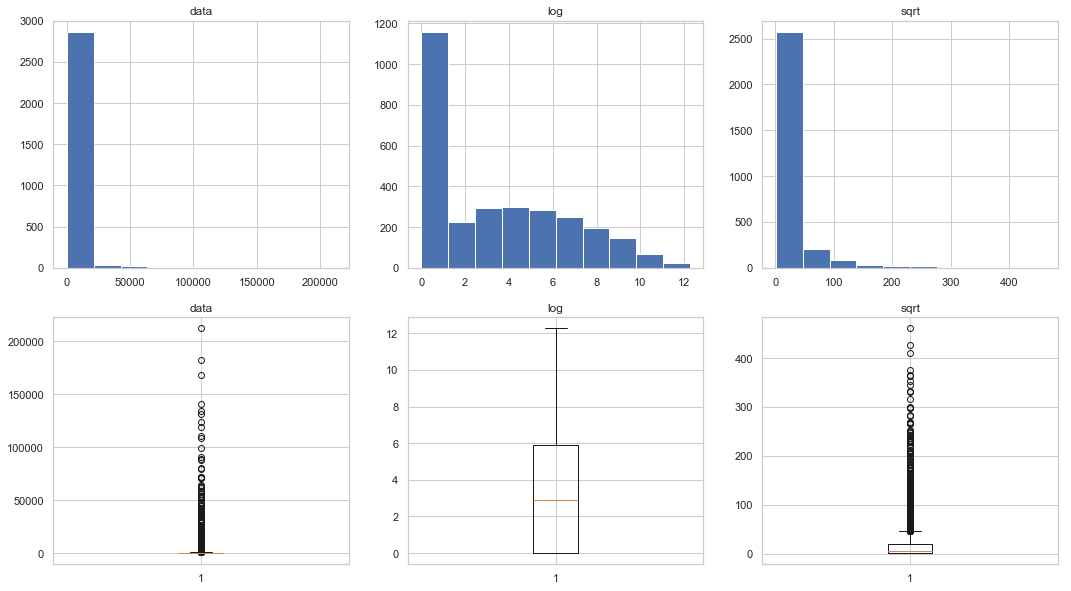

In [43]:
hist_label = df['Measles']

log_views = np.log(hist_label)

sqrt_views = np.sqrt(hist_label)

plt.figure(figsize=(18,10))

plt.subplot(2, 3, 1)
plt.hist(hist_label)
plt.title('data')

plt.subplot(2, 3, 2)
plt.hist(log_views)
plt.title("log")

plt.subplot(2, 3, 3)
plt.hist(sqrt_views)
plt.title("sqrt")

plt.subplot(2, 3, 4)
plt.boxplot(hist_label)
plt.title('data')

plt.subplot(2, 3, 5)
plt.boxplot(log_views)
plt.title("log")

plt.subplot(2, 3, 6)
plt.boxplot(sqrt_views)
plt.title("sqrt")

plt.show()

Log transform of measles removed outliers and slightly improved distribution.

In [44]:
df['under-five deaths'] = df['under-five deaths'] +1 

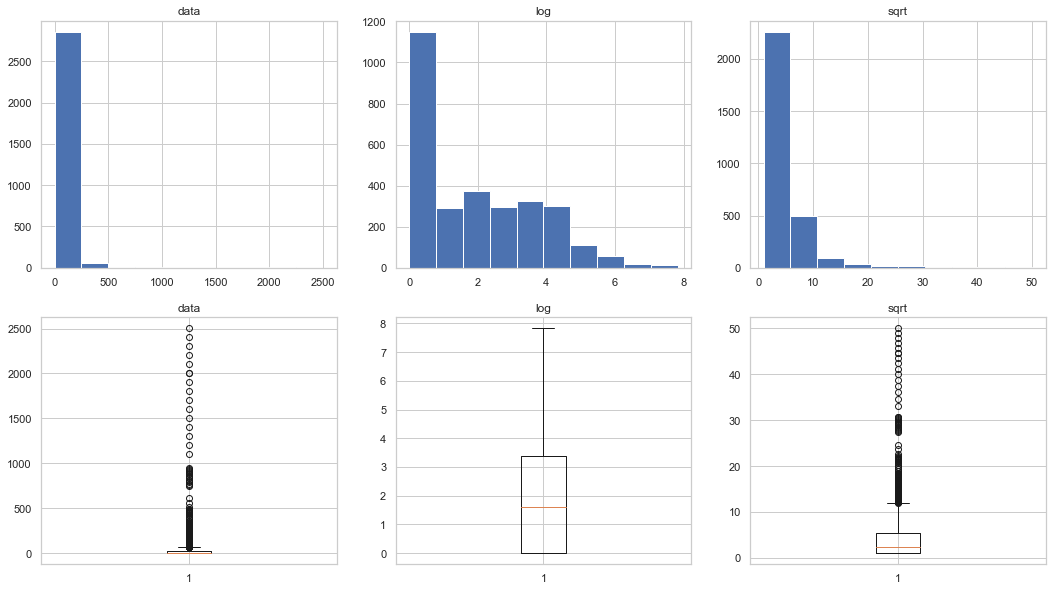

In [45]:
hist_label = df['under-five deaths']

log_views = np.log(hist_label)

sqrt_views = np.sqrt(hist_label)

plt.figure(figsize=(18,10))

plt.subplot(2, 3, 1)
plt.hist(hist_label)
plt.title('data')

plt.subplot(2, 3, 2)
plt.hist(log_views)
plt.title("log")

plt.subplot(2, 3, 3)
plt.hist(sqrt_views)
plt.title("sqrt")

plt.subplot(2, 3, 4)
plt.boxplot(hist_label)
plt.title('data')

plt.subplot(2, 3, 5)
plt.boxplot(log_views)
plt.title("log")

plt.subplot(2, 3, 6)
plt.boxplot(sqrt_views)
plt.title("sqrt")

plt.show()

Log transform of under-five-deaths removed outliers and slightly improved distribution. 


Will do a bivarate analysis below.

In [46]:
df.corr()

,Year,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Polio,Total expenditure,GDP,Population,Income composition of resources,Schooling,Life_expectancy,Adult_Mortality,Measles,BMI,under-five deaths,Diphtheria,thinness 1-19,thinness 5-9,HIV/AIDS
Year,1.000000,-0.037415,-0.064487,0.031400,0.145777,0.095580,0.079345,0.089699,0.019915,0.223818,0.185780,0.168309,-0.079264,-0.082493,0.100417,-0.042937,0.135174,-0.038570,-0.040661,-0.139741
infant deaths,-0.037415,1.000000,-0.114836,-0.085612,-0.200825,-0.169385,-0.126114,-0.107450,0.538589,-0.132327,-0.173790,-0.196197,0.078762,0.501128,-0.226540,0.996629,-0.173944,0.462953,0.467439,0.025231
Alcohol,-0.064487,-0.114836,1.000000,0.337902,0.092366,0.222830,0.289631,0.342275,-0.029223,0.442169,0.507064,0.400068,-0.194070,-0.050497,0.319618,-0.112036,0.218683,-0.420123,-0.408260,-0.048190
percentage expenditure,0.031400,-0.085612,0.337902,1.000000,-0.033524,0.147584,0.169770,0.871453,-0.016310,0.359488,0.369717,0.382069,-0.242587,-0.056596,0.228084,-0.087852,0.144017,-0.252133,-0.253622,-0.097857
Hepatitis B,0.145777,-0.200825,0.092366,-0.033524,1.000000,0.446056,0.088999,0.031839,-0.080645,0.193478,0.201451,0.247419,-0.162578,-0.129531,0.172639,-0.208634,0.532925,-0.141744,-0.150593,-0.117155
Polio,0.095580,-0.169385,0.222830,0.147584,0.446056,1.000000,0.130634,0.196090,-0.028359,0.360154,0.382657,0.459865,-0.272553,-0.135067,0.282080,-0.187343,0.675339,-0.224021,-0.225768,-0.158214
Total expenditure,0.079345,-0.126114,0.289631,0.169770,0.088999,0.130634,1.000000,0.130230,-0.071666,0.161528,0.225940,0.210843,-0.116293,-0.102920,0.233848,-0.127707,0.138987,-0.271898,-0.279073,-0.002109
GDP,0.089699,-0.107450,0.342275,0.871453,0.031839,0.196090,0.130230,1.000000,-0.015225,0.438269,0.422963,0.435854,-0.283332,-0.067382,0.271717,-0.110803,0.185755,-0.284798,-0.289177,-0.133991
Population,0.019915,0.538589,-0.029223,-0.016310,-0.080645,-0.028359,-0.071666,-0.015225,1.000000,0.002498,-0.022782,-0.007126,-0.025440,0.229798,-0.060964,0.526147,-0.015800,0.229123,0.225503,-0.026303
Income composition of resources,0.223818,-0.132327,0.442169,0.359488,0.193478,0.360154,0.161528,0.438269,0.002498,1.000000,0.803152,0.690071,-0.440536,-0.087650,0.461457,-0.149759,0.368009,-0.413490,-0.405924,-0.246793


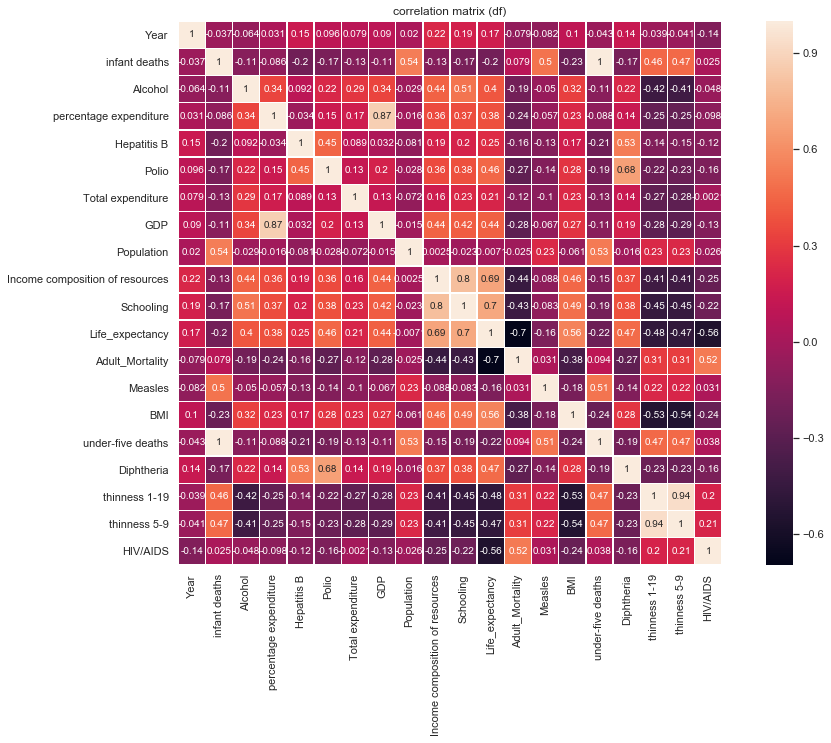

In [113]:
corrmat_df = df.corr()
plt.figure(figsize=(35,10))

plt.subplot(1,2,1)
# Draw the heat map using seaborn
sns.heatmap(corrmat_df, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (df)")

plt.show()

Correlations reveals that under five deaths and infant deaths are perfectly correlated so I will remove infant deaths since they are also captured in remaining variable. 

Both thinness vars are highly correlated and one should be removed, likely the 1-19 which captures most information. 

GDP and percent expenditure or also obviously correlated so we should consider dropping one although I would keep them and decide after testing various models. 


The most highly correlated variables with our target is income comp, schooling. Adult mortality is highly negatively correlated. 

In [110]:
# correlations before removing outliers
df.corr()['Life_expectancy'].sort_values(ascending=False)

Life_expectancy                    1.000000
Schooling                          0.703409
Income composition of resources    0.690071
BMI                                0.556433
Diphtheria                         0.474084
Polio                              0.459865
GDP                                0.435854
Alcohol                            0.400068
percentage expenditure             0.382069
Hepatitis B                        0.247419
Total expenditure                  0.210843
Year                               0.168309
Population                        -0.007126
Measles                           -0.157298
infant deaths                     -0.196197
under-five deaths                 -0.222151
thinness 5-9                      -0.472485
thinness 1-19                     -0.476809
HIV/AIDS                          -0.555929
Adult_Mortality                   -0.695730
Name: Life_expectancy, dtype: float64

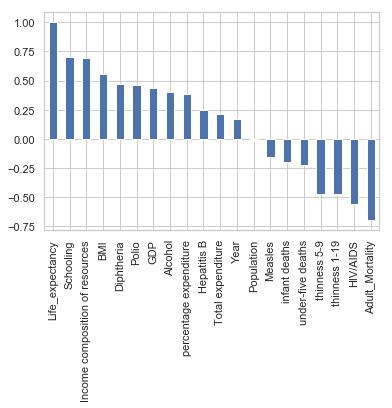

In [111]:
# plot of correlations before removing outliers
df.corr()['Life_expectancy'].sort_values(ascending=False).plot(kind='bar')
plt.show()

Now we need to do a bivarate analysis looking at our categorical data. Will encode Status but not Country as there are too many countries for now. We would also expect life expectancy to get better over time so we can remove that variable as well. If we looked over more years, we might be able to use Year as a predictor but 20 years is too short a window. Will move forward with removing the Countries and Year from the dataset. 


In [50]:
df_clean = df.drop(columns=["Country", 'Year'])

In [51]:
df_clean.Status.value_counts()

Developing    2426
Developed      512
Name: Status, dtype: int64

In [52]:
# encoding binary Status variable

mapping = {"Developed": 1, 'Developing': 0}

df_clean["Status"] = df_clean["Status"].replace(mapping)

df_clean["Status"].value_counts(normalize=True)

0    0.825732
1    0.174268
Name: Status, dtype: float64

In [53]:
df_clean['Status'].describe()

count    2938.000000
mean        0.174268
std         0.379405
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Status, dtype: float64

In [54]:
df_clean.groupby('Status').mean()

,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Polio,Total expenditure,GDP,Population,Income composition of resources,Schooling,Life_expectancy,Adult_Mortality,Measles,BMI,under-five deaths,Diphtheria,thinness 1-19,thinness 5-9,HIV/AIDS
Status,,,,,,,,,,,,,,,,,,,
0,37.384171,3.475699,324.470285,77.424251,80.097898,5.607859,4634.571264,1.334591e+07,1.589451,12.324796,67.107997,182.696002,2825.926216,35.448454,51.525144,79.875927,5.633965,5.685223,2.088664
1,2.494141,9.634141,2704.600380,83.806185,93.736328,7.519257,20687.164283,7.298804e+06,1.847715,16.640031,79.197852,79.685547,500.005859,51.803906,2.810547,93.476562,1.320703,1.296680,0.100000


Looking at the data through Status, we can see some differences in the mean such as higher infant deaths that would certainly push down life expectancy and help predictions within a certain country. We can see that developed countries spend much more on health and have more schooling among many othe differences. These differences between status would likely be significant but we'll do a t test to confirm. 

In [55]:
# Test whether group differences are significant
status = df_clean["Status"].unique()
grouped_df = df_clean.groupby("Status")
for var in ['infant deaths', 'Alcohol',
       'percentage expenditure', 'Hepatitis B', 'Polio', 'Total expenditure',
       'GDP', 'Population', 'Income composition of resources', 'Schooling',
       'Life_expectancy', 'Adult_Mortality', 'Measles', 'BMI',
       'under-five deaths', 'Diphtheria', 'thinness 1-19', 'thinness 5-9',
       'HIV/AIDS']:
    print("------------------------------------------------")
    print("Comparisons for variable: {}".format(var))
    print("------------------------------------------------")
    for i in range(0, len(status)):
        for j in range(i+1, len(status)):
            print("t-test between groups {0} and {1}:".format(status[i], status[j]))
            print(stats.ttest_ind(
                df_clean[df_clean["Status"]==status[i]][var], 
                df_clean[df_clean["Status"]==status[j]][var]
            ))

------------------------------------------------
Comparisons for variable: infant deaths
------------------------------------------------
t-test between groups 0 and 1:
Ttest_indResult(statistic=6.121022910995891, pvalue=1.053344854360067e-09)
------------------------------------------------
Comparisons for variable: Alcohol
------------------------------------------------
t-test between groups 0 and 1:
Ttest_indResult(statistic=-39.07225207455233, pvalue=2.9213563294917682e-269)
------------------------------------------------
Comparisons for variable: percentage expenditure
------------------------------------------------
t-test between groups 0 and 1:
Ttest_indResult(statistic=-27.629292883512814, pvalue=1.4558637811848918e-149)
------------------------------------------------
Comparisons for variable: Hepatitis B
------------------------------------------------
t-test between groups 0 and 1:
Ttest_indResult(statistic=-5.235158751130767, pvalue=1.7646776837220213e-07)
--------------

As expected, the difference between developing and developed is sig diff in all numeric variables. We would likely want to group variables by some criterion such as health, economic or social factors. 

In [56]:
df_clean.describe()

,Status,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Polio,Total expenditure,GDP,Population,Income composition of resources,Schooling,Life_expectancy,Adult_Mortality,Measles,BMI,under-five deaths,Diphtheria,thinness 1-19,thinness 5-9,HIV/AIDS
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.00000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000
mean,0.174268,31.303948,4.548919,739.251295,78.536419,82.474643,5.940955,7432.027910,1.229209e+07,1.634458,13.076804,69.214874,164.744554,2420.592240,38.29869,43.035739,82.246086,4.882301,4.920439,1.742103
std,0.379405,117.926501,3.994854,1987.914858,25.177963,23.420689,2.445751,13410.150286,5.471908e+07,0.209574,3.342316,9.510819,124.226596,11467.272489,19.99140,160.445548,23.705664,4.433359,4.532488,5.077785
min,0.000000,1.000000,0.010000,1.000000,1.000000,3.000000,0.370000,1.681350,3.400000e+01,1.000000,1.000000,36.300000,1.000000,1.000000,1.00000,1.000000,2.000000,0.100000,0.100000,0.100000
25%,0.000000,1.000000,0.902500,5.685343,71.000000,78.000000,4.312500,553.618620,2.536025e+05,1.500000,11.200000,63.100000,74.000000,1.000000,19.32500,1.000000,78.000000,1.600000,1.600000,0.100000
50%,0.000000,4.000000,3.697500,65.912906,89.000000,93.000000,5.760000,2192.681084,1.576319e+06,1.684000,13.400000,72.000000,144.000000,18.000000,43.25000,5.000000,93.000000,3.400000,3.400000,0.100000
75%,0.000000,23.000000,7.550000,442.534144,96.000000,97.000000,7.440000,7183.381694,8.215738e+06,1.791107,15.300000,75.600000,228.000000,361.250000,56.10000,29.000000,97.000000,7.200000,7.300000,0.800000
max,1.000000,1801.000000,17.870000,19480.911610,99.000000,99.000000,17.600000,119172.741800,1.293859e+09,1.948000,21.700000,89.000000,723.000000,212184.000000,87.30000,2501.000000,99.000000,27.700000,28.600000,50.600000


In [92]:
X = StandardScaler().fit_transform(df_clean)
sklearn_pca = PCA(n_components=10)
Y_sklearn = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.33013198 0.13857013 0.09719696 0.064552   0.05623264 0.05129526
 0.03560159 0.03371086 0.02825591 0.02581031]


In [93]:
print(
    'The percentage of total variance in the dataset explained by all 10 components from Sklearn PCA.\n',
    sum(sklearn_pca.explained_variance_ratio_)
)

The percentage of total variance in the dataset explained by all 10 components from Sklearn PCA.
 0.8613576451301387


Using 10 components out of 20 independent variables returns 85% of the data. This is not well interpretable so we need to engineer variables to create fewer features in our model. As explained below. We'll engineer and try PCA with 8 variables to see if we can get fewer principle components.


Will group the mean of Dipthteria, Hepatitis and Polio into a new column called disease_mean. They all failed to respond to transformation to remove outliers or improve distribution. All are moderately positively correlated well with target. 

Will group the mean of 'infant deaths','Adult_Mortality','under-five deaths' in a new column called mortality_mean. They all responded well to transformation to eliminate outliers and improve distribution. All are positively correlated with the target. These variables would obviously help predict life expectancy

Will remove total expenditure since since it's highly + correlated with % expenditures. Percent expenditure more accurately captures money spent on health. Will also remove GDP since it's captured in Status and in percent expenditure. Will remove population since it's not a strong predictor of life expectancy.

Will group and take the mean of measles and HIV. Both responded only moderately well to any transform and are moderately + correlated with target.
'Measles', 'HIV/AIDS'

Will remove thinness varibles since they are somewhat duplicated and go with BMI since it's more highly correlated with target and does not have outliers. 
Income composition of resources is a strongly + correlated with life expectancy. It's also unchanged by transformation.

Will remove status as the info in this variable is somewhat captured in all the variables as we can see from the crosstab above. 

Schooling is unchanged by transformation and has strong + correlated with target.

Will leave alcohol by itself since it doesn't really relate to other features and is unchange by transformation. It's moderately + correlated with target.


Removed variables (as explained above);
* total expenditure
* GDP
* population
* thinness 1-19
* thinness 5-9
* income comp
* status

Unchanged;
* percentage expenditure
* BMI
* Schooling
* Income composition of resources
* alchohol

In [64]:
df_clean.columns

Index(['Status', 'infant deaths', 'Alcohol', 'percentage expenditure',
       'Hepatitis B', 'Polio', 'Total expenditure', 'GDP', 'Population',
       'Income composition of resources', 'Schooling', 'Life_expectancy',
       'Adult_Mortality', 'Measles', 'BMI', 'under-five deaths', 'Diphtheria',
       'thinness 1-19', 'thinness 5-9', 'HIV/AIDS'],
      dtype='object')

In [106]:
df_clean['disease_mean'] = df_clean[['Diphtheria', 'Hepatitis B', 'Polio']].mean(axis=1)
df_clean.describe()

,Status,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Polio,Total expenditure,GDP,Population,Income composition of resources,...,under-five deaths,Diphtheria,thinness 1-19,thinness 5-9,HIV/AIDS,disease_mean,mortality_mean,mortality_log,measlesHiv_mean,measlesHiv_log
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,...,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000
mean,0.174268,31.303948,4.548919,739.251295,78.536419,82.474643,5.940955,7432.027910,1.229209e+07,1.634458,...,43.035739,82.246086,4.882301,4.920439,1.742103,81.085716,79.694747,3.910498,1211.167172,2.811810
std,0.379405,117.926501,3.994854,1987.914858,25.177963,23.420689,2.445751,13410.150286,5.471908e+07,0.209574,...,160.445548,23.705664,4.433359,4.532488,5.077785,20.156462,104.804478,1.026980,5733.715255,3.148820
min,0.000000,1.000000,0.010000,1.000000,1.000000,3.000000,0.370000,1.681350,3.400000e+01,1.000000,...,1.000000,2.000000,0.100000,0.100000,0.100000,4.733333,1.000000,0.000000,0.550000,-0.597837
25%,0.000000,1.000000,0.902500,5.685343,71.000000,78.000000,4.312500,553.618620,2.536025e+05,1.500000,...,1.000000,78.000000,1.600000,1.600000,0.100000,70.863095,28.666667,3.355735,0.650000,-0.430783
50%,0.000000,4.000000,3.697500,65.912906,89.000000,93.000000,5.760000,2192.681084,1.576319e+06,1.684000,...,5.000000,93.000000,3.400000,3.400000,0.100000,90.229167,56.000000,4.025352,9.875000,2.289849
75%,0.000000,23.000000,7.550000,442.534144,96.000000,97.000000,7.440000,7183.381694,8.215738e+06,1.791107,...,29.000000,97.000000,7.200000,7.300000,0.800000,96.000000,96.666667,4.571269,181.550000,5.201531
max,1.000000,1801.000000,17.870000,19480.911610,99.000000,99.000000,17.600000,119172.741800,1.293859e+09,1.948000,...,2501.000000,99.000000,27.700000,28.600000,50.600000,99.000000,1508.666667,7.318982,106094.450000,11.572085


In [107]:
df_clean['mortality_mean'] = df_clean[['infant deaths', 'under-five deaths', 'Adult_Mortality']].mean(axis=1)
df_clean['mortality_log'] = np.log(df_clean['mortality_mean'])
df_clean.describe()

,Status,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Polio,Total expenditure,GDP,Population,Income composition of resources,...,under-five deaths,Diphtheria,thinness 1-19,thinness 5-9,HIV/AIDS,disease_mean,mortality_mean,mortality_log,measlesHiv_mean,measlesHiv_log
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,...,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000
mean,0.174268,31.303948,4.548919,739.251295,78.536419,82.474643,5.940955,7432.027910,1.229209e+07,1.634458,...,43.035739,82.246086,4.882301,4.920439,1.742103,81.085716,79.694747,3.910498,1211.167172,2.811810
std,0.379405,117.926501,3.994854,1987.914858,25.177963,23.420689,2.445751,13410.150286,5.471908e+07,0.209574,...,160.445548,23.705664,4.433359,4.532488,5.077785,20.156462,104.804478,1.026980,5733.715255,3.148820
min,0.000000,1.000000,0.010000,1.000000,1.000000,3.000000,0.370000,1.681350,3.400000e+01,1.000000,...,1.000000,2.000000,0.100000,0.100000,0.100000,4.733333,1.000000,0.000000,0.550000,-0.597837
25%,0.000000,1.000000,0.902500,5.685343,71.000000,78.000000,4.312500,553.618620,2.536025e+05,1.500000,...,1.000000,78.000000,1.600000,1.600000,0.100000,70.863095,28.666667,3.355735,0.650000,-0.430783
50%,0.000000,4.000000,3.697500,65.912906,89.000000,93.000000,5.760000,2192.681084,1.576319e+06,1.684000,...,5.000000,93.000000,3.400000,3.400000,0.100000,90.229167,56.000000,4.025352,9.875000,2.289849
75%,0.000000,23.000000,7.550000,442.534144,96.000000,97.000000,7.440000,7183.381694,8.215738e+06,1.791107,...,29.000000,97.000000,7.200000,7.300000,0.800000,96.000000,96.666667,4.571269,181.550000,5.201531
max,1.000000,1801.000000,17.870000,19480.911610,99.000000,99.000000,17.600000,119172.741800,1.293859e+09,1.948000,...,2501.000000,99.000000,27.700000,28.600000,50.600000,99.000000,1508.666667,7.318982,106094.450000,11.572085


In [75]:
df_clean['measlesHiv_mean'] = df_clean[['Measles', 'HIV/AIDS']].mean(axis=1)
df_clean['measlesHiv_log'] = np.log(df_clean['measlesHiv_mean'])
df_clean.describe()

,Status,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Polio,Total expenditure,GDP,Population,Income composition of resources,...,under-five deaths,Diphtheria,thinness 1-19,thinness 5-9,HIV/AIDS,disease_mean,mortality_mean,mortality_log,measlesHiv_mean,measlesHiv_log
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,...,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000
mean,0.174268,31.303948,4.548919,739.251295,78.536419,82.474643,5.940955,7432.027910,1.229209e+07,1.634458,...,43.035739,82.246086,4.882301,4.920439,1.742103,81.085716,79.694747,3.910498,1211.167172,2.811810
std,0.379405,117.926501,3.994854,1987.914858,25.177963,23.420689,2.445751,13410.150286,5.471908e+07,0.209574,...,160.445548,23.705664,4.433359,4.532488,5.077785,20.156462,104.804478,1.026980,5733.715255,3.148820
min,0.000000,1.000000,0.010000,1.000000,1.000000,3.000000,0.370000,1.681350,3.400000e+01,1.000000,...,1.000000,2.000000,0.100000,0.100000,0.100000,4.733333,1.000000,0.000000,0.550000,-0.597837
25%,0.000000,1.000000,0.902500,5.685343,71.000000,78.000000,4.312500,553.618620,2.536025e+05,1.500000,...,1.000000,78.000000,1.600000,1.600000,0.100000,70.863095,28.666667,3.355735,0.650000,-0.430783
50%,0.000000,4.000000,3.697500,65.912906,89.000000,93.000000,5.760000,2192.681084,1.576319e+06,1.684000,...,5.000000,93.000000,3.400000,3.400000,0.100000,90.229167,56.000000,4.025352,9.875000,2.289849
75%,0.000000,23.000000,7.550000,442.534144,96.000000,97.000000,7.440000,7183.381694,8.215738e+06,1.791107,...,29.000000,97.000000,7.200000,7.300000,0.800000,96.000000,96.666667,4.571269,181.550000,5.201531
max,1.000000,1801.000000,17.870000,19480.911610,99.000000,99.000000,17.600000,119172.741800,1.293859e+09,1.948000,...,2501.000000,99.000000,27.700000,28.600000,50.600000,99.000000,1508.666667,7.318982,106094.450000,11.572085


In [76]:
df.columns

Index(['Country', 'Year', 'Status', 'infant deaths', 'Alcohol',
       'percentage expenditure', 'Hepatitis B', 'Polio', 'Total expenditure',
       'GDP', 'Population', 'Income composition of resources', 'Schooling',
       'Life_expectancy', 'Adult_Mortality', 'Measles', 'BMI',
       'under-five deaths', 'Diphtheria', 'thinness 1-19', 'thinness 5-9',
       'HIV/AIDS'],
      dtype='object')

In [115]:
df_clean2 = df_clean[ ['percentage expenditure', 'BMI','Schooling','Income composition of resources','Alcohol','measlesHiv_log','mortality_log','disease_mean']]
df_clean2.head()

,percentage expenditure,BMI,Schooling,Income composition of resources,Alcohol,measlesHiv_log,mortality_log,disease_mean
0,72.279624,19.1,11.1,1.479,0.01,6.358795,4.917545,45.333333
1,74.523582,18.6,11.0,1.476,0.01,5.507565,4.948760,60.666667
2,74.219243,18.1,10.9,1.470,0.01,5.373193,4.953477,63.333333
3,79.184215,17.6,10.8,1.463,0.01,7.239968,4.979030,67.000000
4,8.097109,17.2,10.5,1.454,0.01,7.317909,4.999462,68.000000


In [120]:
X = StandardScaler().fit_transform(df_clean2)
sklearn_pca = PCA(n_components=5)
Y_sklearn = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.43899843 0.14005739 0.09944393 0.08592054 0.08305856]


In [121]:
print(
    'The percentage of total variance in the dataset explained by all 10 components from Sklearn PCA.\n',
    sum(sklearn_pca.explained_variance_ratio_)
)

The percentage of total variance in the dataset explained by all 10 components from Sklearn PCA.
 0.84747884682562


## Conclusions:

Features in this life expectancy dataset are all important for determining life expectancy which is why they were likely collected to begin with. The goal here is to find fewer predictors that will help us reasonably predict life_expectancy thereby reducing the 21 variables to the smallest model that captures the greatest amount of information from the data. 


Before feature engineering PCA on 20 variables resulted in only 10 components that captured 86% of the variance in the data. This is a lot of variables for 86% however, we did not have to transform any variables to complicate our model. Because all the variables help predict life expectancy and many of them are either duplicated, like thinness or disease, we can easily group the data into fewer variables that suggest high correlation with the target variable. 


After grouping similar variables and removing others for a reduction to 8 variables, PCA results 5 components with 85% of the variance captured. Five components that capture 85% of the variance is acceptable even as it reduces the intpretability of the model prediction because only two variables were logged to remove outliers. 